In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pretty_midi
import numpy as np
import csv

In [91]:
CQT_SNAPSHOT_WIDTH_IN_SECONDS = 5
CQT_SNAPSHOT_WIDTH_IN_PIXELS = 1000 # TODO: is it too high? We should have about one solid colored block per pixel
CQT_SNAPSHOT_HEIGHT_IN_PIXELS = 1000


CQT_SAMPLING_RATE = 86.1

CQT_SLICE_WIDTH_IN_PIXELS = 1
CQT_SLICE_HEIGHT_IN_PIXELS = CQT_SNAPSHOT_HEIGHT_IN_PIXELS

TRAIN_PIANOROLL_WIDTH_IN_PIXELS = 1
TEST_PIANOROLL_WIDTH_IN_SECONDS = 5
TEST_PIANOROLL_WIDTH_IN_PIXELS = float(TEST_PIANOROLL_WIDTH_IN_SECONDS) * TRAIN_PIANOROLL_WIDTH_IN_PIXELS / CQT_SLICE_WIDTH_IN_PIXELS * CQT_SNAPSHOT_WIDTH_IN_PIXELS / CQT_SNAPSHOT_WIDTH_IN_SECONDS

"""
Hyperparameters
"""
CONTEXT_WINDOW_ROWS = 352
CONTEXT_WINDOW_COLS = 9
NUM_RGB_CHANNELS = 1




SAMPLE_RATE_IN_HZ = 1000


Loaded WAV Quadratic Formula Fugue.wav


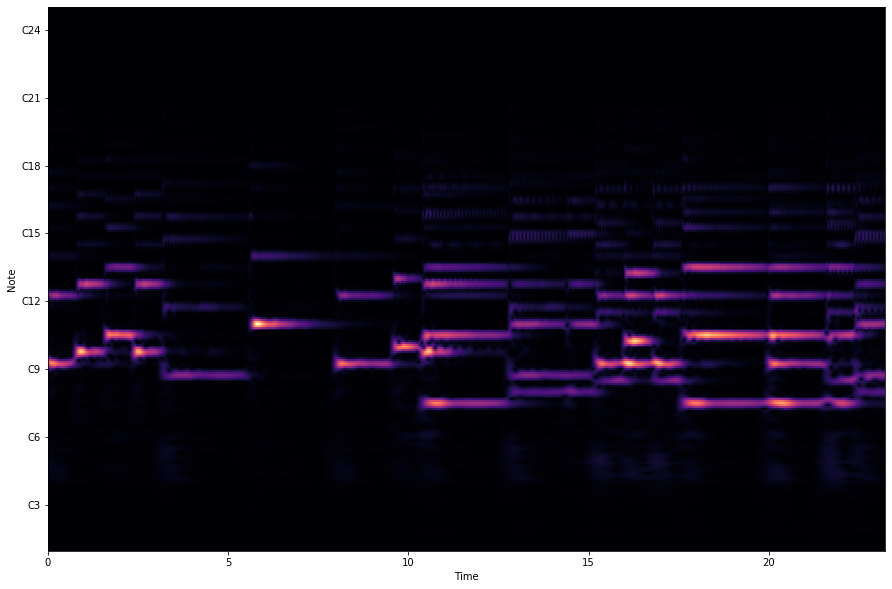

In [184]:
y, sr = librosa.load(path="Quadratic Formula Fugue.wav", sr=None, offset=0)
print("Loaded WAV " + "Quadratic Formula Fugue.wav")
# NOTE: This is where the magic happens. We might want to play around with this CQT generation process.
C = np.abs(librosa.cqt(y, sr=sr, n_bins=(288), hop_length=128, bins_per_octave=36, filter_scale=0.5))

plt.figure(figsize=(15, 10))
librosa.display.specshow(C[:, 2000:4000], sr=sr, x_axis='time', y_axis='cqt_note')

The optimal parameters appear to be:
 * filter_scale = 0.5
 * bins_per_octave = 36
 * hop_length = 128

## Figure out the resolution (hop length) of the CQT plot

In [101]:
print("Total CQT samples:", C.shape[1])
print("Total WAV samples:", len(y), "at sample rate", sr)
print("WAV samples per CQT sample:", len(y) / (C.shape[1] - 1))

Total CQT samples: 18417
Total WAV samples: 2357248 at sample rate 44100
WAV samples per CQT sample: 128.0


In [105]:
# Try the same thing with a different WAV

y, sr = librosa.load(path="Maria.wav", sr=None, offset=0)
print("Loaded WAV " + "Maria.wav")
# NOTE: This is where the magic happens. We might want to play around with this CQT generation process.
D = np.abs(librosa.cqt(y, sr=sr, n_bins=(264), hop_length=128, bins_per_octave=36, filter_scale=0.8))

print("Total CQT samples:", D.shape[1])
print("Total WAV samples:", len(y), "at sample rate", sr)
print("WAV samples per CQT sample:", len(y) / (D.shape[1] - 1))

Loaded WAV Maria.wav
Total CQT samples: 21465
Total WAV samples: 2747392 at sample rate 44100
WAV samples per CQT sample: 128.0


For some reason, librosa's cqt() function adds an extra frame, but otherwise, it does appear to have a predictable sampling rate. *This means we need to change some constants*.

## Now look at pretty_midi alignment

In [92]:
def get_ground_truth_labels_at_time(piano_roll, time):
    """
    Takes in a piano roll (created with 1000Hz sampling rate) representation of a MIDI 
    and a time in milliseconds and returns a (88, 1) vector of ground truth labels.
    """
    # NOTE: The result is a vector of 1s and 0s
    if time >= len(piano_roll[0]):
        return False
    return piano_roll[:,time]


def get_piano_roll_subdivided_by_ms(midi_path, sampling_rate=SAMPLE_RATE_IN_HZ):
    """
    Returns an np array that is a piano roll representation of a midi file, cropping the
    128 note values in MIDI to the 88 notes of a piano keyboard.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    raw_piano_roll = midi_data.get_piano_roll(fs=sampling_rate, times=None)
    piano_roll = raw_piano_roll > 0
    # 21 extra at bottom of range (C-1 -> G#0), 19 extra at top (C#8 -> G9)
    return np.asarray(piano_roll[19:-21]).astype(int) # TODO: look at piano check to make sure we're removing the 
                                    # right one (not flipped top/bottom)... else [21:-19]

### LOOK AT THIS
def format_piano_roll_for_midi(piano_roll_path):
    """
    Takes in path to piano roll csv and reads csv into numpy array. Adds 19 rows pertaining 
    to the highest values and 21 rows pertaining to the lowest values to the piano roll.
    """
    # NOTE: This is used to prepare a pianoroll matrix for conversion back into a midi, for listening.
    small_piano_roll = np.genfromtxt(piano_roll_path, delimiter='\t')
    piano_roll_length = small_piano_roll.shape[1]
    piano_roll = np.insert(small_piano_roll, 0, np.zeros((19,piano_roll_length)), axis=0)
    piano_roll = np.insert(piano_roll, piano_roll.shape[0], np.zeros((21,piano_roll_length)), axis=0)
    return piano_roll.astype(int)

In [104]:
pianoroll = get_piano_roll_subdivided_by_ms("Quadratic Formula Fugue.mid", sampling_rate=(sr / 128))
print("Actual number of pianoroll samples:", pianoroll.shape[1])
print("Expected number of pianoroll samples:", C.shape[1])
print("Ratio between expected:", pianoroll.shape[1] / C.shape[1])

Actual number of pianoroll samples: 17756
Expected number of pianoroll samples: 18417
Ratio between expected: 0.9641092468914589


It doesn't line up! Let's try again with the other piece.

In [107]:
pianoroll = get_piano_roll_subdivided_by_ms("Maria.mid", sampling_rate=(sr / 128))
print("Actual number of pianoroll samples:", pianoroll.shape[1])
print("Expected number of pianoroll samples:", D.shape[1])
print("Ratio between expected:", pianoroll.shape[1] / D.shape[1])

Actual number of pianoroll samples: 20878
Expected number of pianoroll samples: 21465
Ratio between expected: 0.9726531563009551


Yikes. It's off by a different amount. Let's dig in to see what's wrong.

In [112]:
midi_path = "Maria.mid"
sampling_rate = sr / 128

midi_data = pretty_midi.PrettyMIDI(midi_path)
raw_piano_roll = midi_data.get_piano_roll(fs=sampling_rate, times=None)
raw_piano_roll.shape[1]

20878

Welp, so much for that. Let's plot each onset from the MIDI on top of the CQT.

In [117]:
# Converts output pianoroll into just a true followed by falses for onsets.
def format(outputPianoroll):
    # NOTE: Iterate through keyboard note by keyboard note
    for i, row in enumerate(outputPianoroll):
        isPrevOn = False
        # NOTE: Iterate through time slices for just this note's pianoroll
        for j, isOn in enumerate(row):
            # TODO: don't penalize an erroneous rearticulation as much as any note that doesn't belong
            if isOn:
                if isPrevOn:
                    outputPianoroll[i, j] = False
                isPrevOn = True
            else:
                isPrevOn = False

In [200]:
pianoroll = get_piano_roll_subdivided_by_ms("Maria.mid", sampling_rate=(sr / 128))

# Convert pianoroll to just onsets
output_pianoroll = np.copy(pianoroll)
format(output_pianoroll)

# Sum over note axis to get all onsets
onsets = np.sum(output_pianoroll, axis=0)
for i in range(len(onsets) - 2, 0, -1):
    if onsets[i]:
        onsets[i] = 0
        onsets[i+3] = 1
        onsets[i+4] = 1
        onsets[i+5] = 1
        onsets[i+6] = 1
        onsets[i+7] = 1
#         onsets[i+2] = 1
#         onsets[i+3] = 1
#         onsets[i+4] = 1
#         onsets[i+5] = 1
#         onsets[i+6] = 1
#         onsets[i+7] = 1
        
onsets_output = np.where(onsets, 5, 0)

Displaying last 2000 frames:


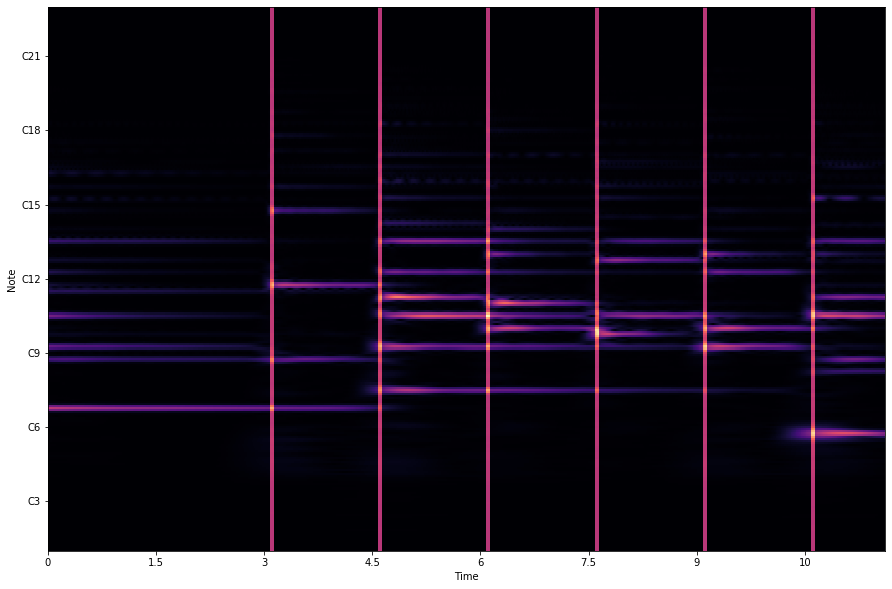

In [203]:
E = np.copy(D)
E[:, :len(onsets_output)] += onsets_output
plt.figure(figsize=(15, 10))

print("Displaying last 2000 frames:")
librosa.display.specshow(E[:, 4000:5000], sr=sr, x_axis='time', y_axis='cqt_note')

It lines up perfectly! The second issue is just that the pianoroll is a variable amount shorter than the CQT (the MIDI might very well be "shorter" than the WAV). We should trim the CQTs down to the size of the pianoroll.

## Summary

Set the following parameters:
 * filter_scale = 0.5
 * bins_per_octave = 36
 * hop_length = 128
 
Set the constant CQT_SAMPLING_RATE = 344.53125 (which is 44100 / 128).

Set the constant CQT_SLICE_WIDTH_IN_PIXELS = 5.